## Group gene expression by time

In [1]:
import os
import re
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

### *Step 1: read all raw data*

In [2]:
DATA_PATH = r'../../dataset/'
mapper = lambda x : x[1:] # removes leading 'x' char in idx strings
genes = ["amon","brp","cac","Cadps","Fife","Liprin-alpha","Pdf","Rab27","Rab3",
         "Rbp","RhoGAP100F","Rim","Snap25","Syb","Syt1","Syt12","Syt14","Syt4",
         "Syt7","Sytalpha","Sytbeta","Syx13","Syx16","Syx17","Syx18","Syx4",
         "Syx5","Syx6","Syx7","Syx8","unc-13"]
# couldn't find syx1A in dataset...

In [3]:
genexp_df = None
for filename in os.listdir(DATA_PATH):
    new_df = pd.read_csv(os.path.join(DATA_PATH, filename), index_col=0).loc[genes]
    new_df = new_df.rename(mapper, axis='columns').T
    if genexp_df is None:
        genexp_df = new_df
        continue
    genexp_df = pd.concat([genexp_df, new_df])
genexp_df

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx13,Syx16,Syx17,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,1,0,0,0,0,2,7,1,0,16
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,0,0,0,0,1,2,0,25
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_TGGTGA,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20190309_CLK856_LD_ZT22_AR02_TGGTTG,0,1,0,3,0,0,19,0,1,2,...,0,0,0,0,0,0,0,0,0,5
20190309_CLK856_LD_ZT22_AR02_TGTCAC,2,5,13,9,0,4,60,0,4,4,...,1,0,0,0,0,1,0,1,0,11
20190309_CLK856_LD_ZT22_AR02_TGTCGA,0,0,0,2,0,0,284,0,0,1,...,0,0,0,0,0,0,0,0,1,3


### *Step 2: extract date, experiment type, and time for each neuron*

In [7]:
def get_date(neuron: str) -> date:
    """
    Extracts date data from singular index
    :param neuron: string representing single neuron
    :return: date data
    """
    date_pattern = re.compile(r'(20\d\d)(\d\d)(\d\d)')
    match = date_pattern.search(neuron)
    if not match:
        raise ValueError(f'Date not found in {neuron}')
    year, month, day = tuple([int(x) for x in match.groups()])
    if month == 0:
        month = 1
    return date(year, month, day)


def get_exp(neuron: str) -> str:
    """
    Get experiment (DD || LD) applied to the neuron
    :param neuron:
    :return: string 'DD' or 'LD'
    """
    exp_re = re.compile(r"(_)(DD|LD)(_)")
    match = exp_re.search(neuron)
    if not match:
        raise ValueError(f'Experiment not found in {neuron}')
    return match.group(2)


def get_time(neuron: str) -> str:
    """
    Same as above, capturing ZT or CT time
    :param neuron: single neuron name
    :return: ZTXX or CTXX
    """
    time_pattern = re.compile(r'(CT|ZT)(\d\d)')
    match = time_pattern.search(neuron)
    if not match:
        raise ValueError(f'Time not found in {neuron}')
    return match.group()


test_str = '20190528_CLK856_DD_CT02_AR05_ACGTAC'
exp_date = get_date(test_str)
experiment = get_exp(test_str)
exp_time = get_time(test_str)
print(f"{exp_date=}")
print(f"{experiment=}")
print(f"{exp_time=}")

exp_date=datetime.date(2019, 5, 28)
experiment='DD'
exp_time='CT02'


In [8]:
indeces = genexp_df.index.to_series()
genexp_df['date'] = indeces.map(get_date)
genexp_df['experiment'] = indeces.map(get_exp)
genexp_df['exp_time'] = indeces.map(get_time)
genexp_df

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,experiment,exp_time
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,0,0,2,7,1,0,16,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,0,1,2,0,25,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,0,1,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,2019-05-28,DD,CT02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_TGGTGA,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,2019-03-09,LD,ZT22
20190309_CLK856_LD_ZT22_AR02_TGGTTG,0,1,0,3,0,0,19,0,1,2,...,0,0,0,0,0,0,5,2019-03-09,LD,ZT22
20190309_CLK856_LD_ZT22_AR02_TGTCAC,2,5,13,9,0,4,60,0,4,4,...,0,0,1,0,1,0,11,2019-03-09,LD,ZT22
20190309_CLK856_LD_ZT22_AR02_TGTCGA,0,0,0,2,0,0,284,0,0,1,...,0,0,0,0,0,1,3,2019-03-09,LD,ZT22


### *Step 3: group by cluster (for instance, keep 's_LNv')*

In [9]:
ANNOT_PATH = 'clock_neuron_clusters.csv'
annot_df = pd.read_csv(ANNOT_PATH, index_col=0)
annot_df

,experiment,time,Repeats,Idents
20181215_CLK856_LD_ZT14_AR07_ACAGGA,CLK856_LD,zt14,LD_2,29:LPN
20181215_CLK856_LD_ZT14_AR07_CTTCTG,CLK856_LD,zt14,LD_2,29:LPN
20181231_CLK856_LD_ZT14_AR02_GTACCA,CLK856_LD,zt14,LD_1,29:LPN
20181231_CLK856_LD_ZT14_AR02_TCCTTC,CLK856_LD,zt14,LD_1,29:LPN
20181231_CLK856_LD_ZT14_AR08_AGACAG,CLK856_LD,zt14,LD_1,29:LPN
...,...,...,...,...
20190710_CLK856_DD_CT06_AR04_GTCTTC,CLK856_DD,zt06,DD_1,1:DN1p_CNMa
20190710_CLK856_DD_CT06_AR04_TCCTTC,CLK856_DD,zt06,DD_1,1:DN1p_CNMa
20190719_CLK856_DD_CT06_AR18_GTCTTC,CLK856_DD,zt06,DD_2,1:DN1p_CNMa
20190814_CLK856_DD_CT06_AR19_TCTGCA,CLK856_DD,zt06,DD_2,1:DN1p_CNMa


In [10]:
genexp_clusters_df = genexp_df.merge(annot_df[['Idents']], left_index=True, right_index=True, how='left')
genexp_clusters_df

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,experiment,exp_time,Idents
20190528_CLK856_DD_CT02_AR05_ACAGAC,35,8,20,6,6,4,59,1,7,4,...,0,2,7,1,0,16,2019-05-28,DD,CT02,6:DN1p
20190528_CLK856_DD_CT02_AR05_ACAGGA,6,8,7,6,14,3,50,0,4,14,...,0,0,1,2,0,25,2019-05-28,DD,CT02,NaN
20190528_CLK856_DD_CT02_AR05_ACAGTG,1,0,1,1,0,0,3,0,0,0,...,0,0,0,1,0,0,2019-05-28,DD,CT02,NaN
20190528_CLK856_DD_CT02_AR05_ACCAAC,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2019-05-28,DD,CT02,NaN
20190528_CLK856_DD_CT02_AR05_ACCAGA,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,2019-05-28,DD,CT02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_TGGTGA,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,2019-03-09,LD,ZT22,NaN
20190309_CLK856_LD_ZT22_AR02_TGGTTG,0,1,0,3,0,0,19,0,1,2,...,0,0,0,0,0,5,2019-03-09,LD,ZT22,NaN
20190309_CLK856_LD_ZT22_AR02_TGTCAC,2,5,13,9,0,4,60,0,4,4,...,0,1,0,1,0,11,2019-03-09,LD,ZT22,1:DN1p_CNMa
20190309_CLK856_LD_ZT22_AR02_TGTCGA,0,0,0,2,0,0,284,0,0,1,...,0,0,0,0,1,3,2019-03-09,LD,ZT22,NaN


In [16]:
LNv_df = genexp_clusters_df[(genexp_clusters_df['Idents'] == '2:s_LNv') \
                            | (genexp_clusters_df['Idents'] == '25:l_LNv')]
LNv_df

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,experiment,exp_time,Idents
20190528_CLK856_DD_CT02_AR05_CTAGTG,4,0,3,1,0,0,610,1,1,3,...,1,0,0,10,0,5,2019-05-28,DD,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR05_GACAAC,88,6,34,8,53,3,1797,0,18,2,...,0,2,3,10,0,34,2019-05-28,DD,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR06_ACCAGA,108,25,25,14,53,18,2444,2,69,24,...,1,2,1,8,0,51,2019-05-28,DD,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR07_CAGAAG,8,9,6,3,16,2,1191,0,22,2,...,1,2,0,6,3,10,2019-05-28,DD,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR07_GAGTAC,129,20,55,21,45,19,1839,0,75,15,...,3,0,3,4,3,63,2019-05-28,DD,CT02,2:s_LNv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_AGGAAG,10,8,13,5,10,6,874,0,19,14,...,0,2,4,0,0,53,2019-03-09,LD,ZT22,2:s_LNv
20190309_CLK856_LD_ZT22_AR02_AGGACA,4,4,17,13,7,0,627,0,13,14,...,0,0,0,1,1,36,2019-03-09,LD,ZT22,2:s_LNv
20190309_CLK856_LD_ZT22_AR02_GACATG,6,4,8,8,19,2,981,0,17,5,...,0,0,5,0,0,37,2019-03-09,LD,ZT22,2:s_LNv
20190309_CLK856_LD_ZT22_AR02_TCACTC,19,16,14,14,6,7,3511,0,29,8,...,0,4,7,4,1,80,2019-03-09,LD,ZT22,25:l_LNv


### *Step 4: group by experiment (for instance, keep 'DD')*

In [17]:
LNv_LD = LNv_df[LNv_df['experiment'] == 'LD'].drop('experiment', axis='columns')
LNv_LD

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,exp_time,Idents
20190309_CLK856_LD_ZT02_AR08_ACCAAC,94,24,20,40,36,6,2262,0,38,17,...,0,0,0,8,12,0,76,2019-03-09,ZT02,2:s_LNv
20190309_CLK856_LD_ZT02_AR08_ACGTGA,64,19,32,17,82,18,1524,0,77,31,...,0,1,2,2,4,0,84,2019-03-09,ZT02,2:s_LNv
20190309_CLK856_LD_ZT02_AR08_AGACAG,19,11,15,17,23,2,1255,0,23,13,...,0,0,1,1,0,0,50,2019-03-09,ZT02,2:s_LNv
20190309_CLK856_LD_ZT02_AR08_AGTGTC,128,17,33,22,32,11,1646,1,58,15,...,0,0,1,1,1,0,67,2019-03-09,ZT02,2:s_LNv
20190309_CLK856_LD_ZT02_AR08_CTGTAC,119,17,38,15,139,24,1826,0,61,21,...,0,2,0,3,1,0,131,2019-03-09,ZT02,2:s_LNv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190309_CLK856_LD_ZT22_AR02_AGGAAG,10,8,13,5,10,6,874,0,19,14,...,0,0,2,4,0,0,53,2019-03-09,ZT22,2:s_LNv
20190309_CLK856_LD_ZT22_AR02_AGGACA,4,4,17,13,7,0,627,0,13,14,...,0,0,0,0,1,1,36,2019-03-09,ZT22,2:s_LNv
20190309_CLK856_LD_ZT22_AR02_GACATG,6,4,8,8,19,2,981,0,17,5,...,0,0,0,5,0,0,37,2019-03-09,ZT22,2:s_LNv
20190309_CLK856_LD_ZT22_AR02_TCACTC,19,16,14,14,6,7,3511,0,29,8,...,0,0,4,7,4,1,80,2019-03-09,ZT22,25:l_LNv


In [18]:
LNv_DD = LNv_df[LNv_df['experiment'] == 'DD'].drop('experiment', axis='columns')
LNv_DD

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,exp_time,Idents
20190528_CLK856_DD_CT02_AR05_CTAGTG,4,0,3,1,0,0,610,1,1,3,...,0,1,0,0,10,0,5,2019-05-28,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR05_GACAAC,88,6,34,8,53,3,1797,0,18,2,...,0,0,2,3,10,0,34,2019-05-28,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR06_ACCAGA,108,25,25,14,53,18,2444,2,69,24,...,0,1,2,1,8,0,51,2019-05-28,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR07_CAGAAG,8,9,6,3,16,2,1191,0,22,2,...,0,1,2,0,6,3,10,2019-05-28,CT02,2:s_LNv
20190528_CLK856_DD_CT02_AR07_GAGTAC,129,20,55,21,45,19,1839,0,75,15,...,0,3,0,3,4,3,63,2019-05-28,CT02,2:s_LNv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190704_CLK856_DD_CT22_AR14_ACAGAC,33,1,16,5,10,4,739,2,16,5,...,0,2,0,1,3,0,5,2019-07-04,CT22,2:s_LNv
20190704_CLK856_DD_CT22_AR14_ACTCTG,8,3,3,4,7,0,878,0,20,7,...,0,0,0,0,3,0,10,2019-07-04,CT22,2:s_LNv
20190704_CLK856_DD_CT22_AR14_CAACTC,5,0,7,0,9,1,520,0,1,0,...,0,0,2,3,0,0,3,2019-07-04,CT22,2:s_LNv
20190704_CLK856_DD_CT22_AR14_CATGAG,2,2,24,0,5,0,612,0,0,7,...,0,0,0,1,6,0,3,2019-07-04,CT22,2:s_LNv


Check data integrity

In [19]:
len(LNv_DD) + len(LNv_LD) == len(LNv_df)

True

In [20]:
save = input("Save LNv_DD.csv, LNv_LD.csv? [y/n]: ")
if save.strip().lower() == 'y':
    LNv_DD.to_csv('LNv_DD.csv')
    LNv_LD.to_csv('LNv_LD.csv')

### *Step 4: group by time*

In [13]:
s_LNv_DD = pd.read_csv('s_LNv_DD.csv', index_col=0)
s_LNv_DD.head(10)

,amon,brp,cac,Cadps,Fife,Liprin-alpha,Pdf,Rab27,Rab3,Rbp,...,Syx17,Syx18,Syx4,Syx5,Syx6,Syx7,Syx8,unc-13,date,exp_time
20190528_CLK856_DD_CT02_AR05_CTAGTG,4,0,3,1,0,0,610,1,1,3,...,0,0,1,0,0,10,0,5,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR05_GACAAC,88,6,34,8,53,3,1797,0,18,2,...,2,0,0,2,3,10,0,34,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR06_ACCAGA,108,25,25,14,53,18,2444,2,69,24,...,14,0,1,2,1,8,0,51,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR07_CAGAAG,8,9,6,3,16,2,1191,0,22,2,...,0,0,1,2,0,6,3,10,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR07_GAGTAC,129,20,55,21,45,19,1839,0,75,15,...,1,0,3,0,3,4,3,63,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR08_ACAGTG,76,8,20,10,63,3,1305,0,21,15,...,0,4,2,0,3,0,0,17,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR08_CTCAGA,2,2,9,4,8,2,556,0,1,3,...,1,0,2,0,0,1,0,4,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR08_GTACCA,10,5,5,3,40,1,1068,0,5,6,...,1,0,0,8,3,8,0,3,2019-05-28,CT02
20190528_CLK856_DD_CT02_AR08_TCACAG,13,3,9,1,7,1,561,0,4,4,...,0,0,0,1,0,22,0,12,2019-05-28,CT02
20190702_CLK856_DD_CT02_AR13_GACATG,28,1,0,0,28,1,545,0,5,3,...,3,1,0,0,0,1,0,17,2019-07-02,CT02


In [14]:
count_df = s_LNv_DD[s_LNv_DD != 0]\
                    .drop('date', axis='columns')\
                    .groupby('exp_time')\
                    .count().T

In [15]:
mean_df = s_LNv_DD[s_LNv_DD != 0]\
                    .drop('date', axis='columns')\
                    .groupby('exp_time')\
                    .mean().T

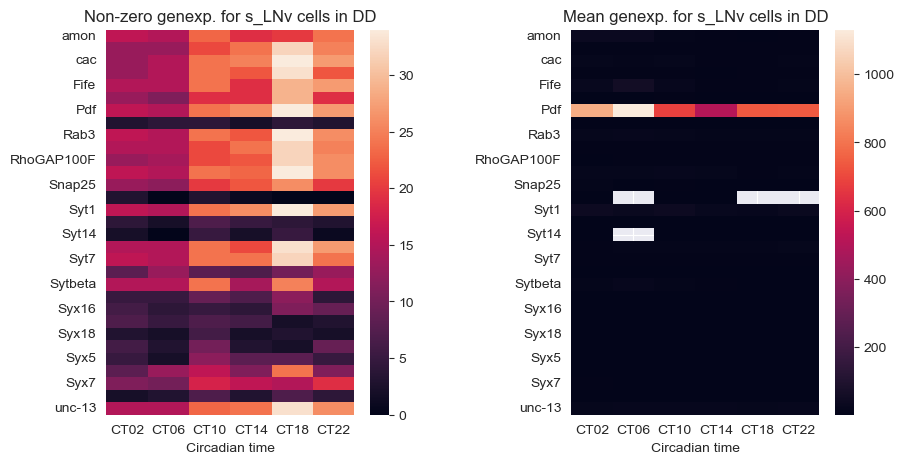

In [19]:
fig_h, axs_h = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(count_df, ax=axs_h[0])
axs_h[0].set_title('Non-zero genexp. for s_LNv cells in DD')
axs_h[0].set_xlabel('Circadian time')
sns.heatmap(mean_df, ax=axs_h[1])
axs_h[1].set_title('Mean genexp. for s_LNv cells in DD')
axs_h[1].set_xlabel('Circadian time')
plt.subplots_adjust(wspace=0.5)
plt.savefig('DD_s_LNv_heatmaps.png')

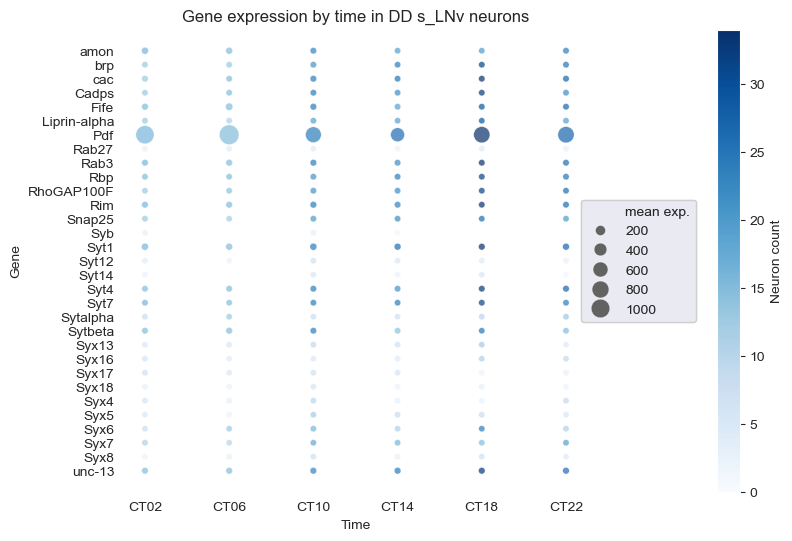

In [18]:
# melt and combine dataframes
count_melted = count_df.reset_index().melt(id_vars='index', var_name='column', value_name='cell count')
mean_melted = mean_df.reset_index().melt(id_vars='index', var_name='column', value_name='mean exp.')
merged_df = pd.merge(count_melted, mean_melted, on=['index', 'column'])

# create dot plot
fig, ax = plt.subplots(figsize=(9, 6))
scatter = sns.scatterplot(data=merged_df, x='column', y='index', size='mean exp.', hue='cell count',
                          palette='Blues', sizes=(20, 200), legend='brief', edgecolor='w', alpha=0.7)
scatter.set(facecolor='white')
# create a colorbar
norm = plt.Normalize(count_df.values.min(), count_df.values.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter.axes, pad=0.02)
cbar.set_label('Neuron count')

# legend with scales
handles, labels = scatter.get_legend_handles_labels()
box = scatter.get_position()
scatter.set_position([box.x0, box.y0, box.width * 0.8, box.height])
size_legend = plt.legend(handles[-len(mean_df.columns):], labels[-len(mean_df.columns):],
                         loc="center right", bbox_to_anchor=(1.25, 0.5), frameon=True)
plt.gca().add_artist(size_legend)

# titles and labels
plt.title('Gene expression by time in DD s_LNv neurons')
plt.xlabel('Time')
plt.ylabel('Gene')
plt.savefig('DD_s_LNv_genexp.png')
plt.show()